# Exploring the Research Topics of Virtual Influencers Marketing
## Using Efficiency Language Model: en_core_web_sm

&copy; Anika Nissen

Based on and adapted from the steps described here: https://gist.github.com/sg-tarek/fac6e2da92744cdfd1e9b29201f4b614.js


In [1]:
#import importlib

# Import all of the required libs
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# This provides us the nlp pipeline for tokenization and pre-trained language models as well as sentiment analysis
import spacy
#import en_core_web_md

# This provides the actual models that are used to create the different topics
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, TfidfModel
from gensim.models.nmf import Nmf as GensimNmf

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

# Additional imports for ngrams
from nltk import ngrams
from nltk.corpus import stopwords

/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


## Step 1: Load the data and get an impression on the data structure

In [2]:
#Import data and have a look at data

reports = pd.read_csv('SociaMediaInfluencer-ScopusData.csv') 
reports.head()

,Authors,Title,Year,Source title,DOI,Link,Abstract
0,"Donofrio A., Moraga Á.L.R., Guzmán C.A.","Russia-Ukraine, a comparative analysis of the ...",2023,Revista Latina de Comunicacion Social,10.4185/RLCS-2023-1819,https://www.scopus.com/inward/record.uri?eid=2...,"Introduction: On February 24, 2022, the Russia..."
1,"Thomas V.L., Fowler K.",Examining the outcomes of influencer activism,2023,Journal of Business Research,10.1016/j.jbusres.2022.113336,https://www.scopus.com/inward/record.uri?eid=2...,Academic research on influencer marketing is b...
2,"Barta S., Belanche D., Fernández A., Flavián M.",Influencer marketing on TikTok: The effectiven...,2023,Journal of Retailing and Consumer Services,10.1016/j.jretconser.2022.103149,https://www.scopus.com/inward/record.uri?eid=2...,This work examines the determinants of the suc...
3,"Zhao L., Zhang M., Ming Y., Niu T., Wang Y.",The effect of image richness on customer engag...,2023,Journal of Business Research,10.1016/j.jbusres.2022.113307,https://www.scopus.com/inward/record.uri?eid=2...,Despite the dominant role of images on social ...
4,"Taufiq M., Farida N., Aryanto V.D.W., Ngatno",Evaluating Factor Influencing Consumer Purchas...,2023,Lecture Notes in Networks and Systems,10.1007/978-3-031-08093-7_30,https://www.scopus.com/inward/record.uri?eid=2...,This study mainly aimed to examine the factors...


In [3]:
# Get info on the data structure
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Authors       1882 non-null   object
 1   Title         1882 non-null   object
 2   Year          1882 non-null   int64 
 3   Source title  1882 non-null   object
 4   DOI           1702 non-null   object
 5   Link          1882 non-null   object
 6   Abstract      1882 non-null   object
dtypes: int64(1), object(6)
memory usage: 103.0+ KB


In [4]:
# Drop rows with empty Beschreibung and merge Text written in Zusammenfassung and Beschreibung together into one column named "Abstract"
reports = reports[reports['Abstract'].notna()]

reports['Abstract']= reports['Abstract'].astype(str)
reports['Abstract']

0       Introduction: On February 24, 2022, the Russia...
1       Academic research on influencer marketing is b...
2       This work examines the determinants of the suc...
3       Despite the dominant role of images on social ...
4       This study mainly aimed to examine the factors...
                              ...                        
1877    Social media influencers (SMIs) represent a ne...
1878    Social media enables the brand to extend its p...
1879    The role of Twitter - a form of microblogging ...
1880    The proceedings contain 33 papers. The topics ...
1881    Influencer Marketing is the most important new...
Name: Abstract, Length: 1882, dtype: object

In [5]:
# Is only required if specific words are to be deleted
# Option to store word list that is to be removed in a txt and read it in from there

#removewords = ['word1', 'word2', 'wordn']

#for i in removewords:
#    reports['Abstract'] = reports['Abstract'].str.replace(i,' ', case=False)
    
#reports['Abstract']    

## Step 2: Preprocess the data with SpaCy
Using Compilation of N-Grams and then the SpaCy Pipeline for Preprocessing of the data.
This draws on a general model which is pre-trained on a large body of German News Articles.

In [6]:
# Our spaCy model:
import en_core_web_sm
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("merge_noun_chunks")
nlp.add_pipe("merge_entities")

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [7]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'merge_noun_chunks',
 'merge_entities']

In [8]:
# This is a manual option to consider n-grams, however, this just chunks the text
# into bigrams and trigrams without understanding context
'''
# First let's define the ngrams:
def compile_ngrams(text, number_of_n=3, include_unigrams=True):
  ngram_list = []
  # number_of_n controls up to how many n we build an ngram for
  # 2 being bigrams, 3 being trigrams, ect.
  for n in range(number_of_n):
    if n == 0 and not include_unigrams:
      continue
    for ngram in ngrams(text.split(), n + 1):
      ngram_list.append(' '.join(ngram))
  return ngram_list

compile_ngrams('Abstract')
'''

"\n# First let's define the ngrams:\ndef compile_ngrams(text, number_of_n=3, include_unigrams=True):\n  ngram_list = []\n  # number_of_n controls up to how many n we build an ngram for\n  # 2 being bigrams, 3 being trigrams, ect.\n  for n in range(number_of_n):\n    if n == 0 and not include_unigrams:\n      continue\n    for ngram in ngrams(text.split(), n + 1):\n      ngram_list.append(' '.join(ngram))\n  return ngram_list\n\ncompile_ngrams('Abstract')\n"

In [9]:
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

# Looping through text to tokenize the whole thing
for summary in nlp.pipe(reports['Abstract']):
    proj_tok = [token.lemma_.lower() for token in summary 
                if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    
    #unigrams = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    #proj_tok = compile_ngrams(" ".join(unigrams), number_of_n=3, include_unigrams=False)

    tokens.append(proj_tok)

In [10]:
# Compute bigrams.
from gensim.models import Phrases

docs=reports['Abstract'].values.tolist()

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            tokens[idx].append(token)

In [11]:
reports['tokens'] = tokens
reports['tokens']

0       [introduction, ukraine, begin, spread, invaded...
1       [prevalent, take, advise, company, good, partn...
2       [examine, analyse, originality, quality, quant...
3       [despite, image, evaluate, limit, propose, mea...
4       [aim, examine, influence, include, cash, deliv...
                              ...                        
1877    [smis, represent, shape, blog, tweet, identify...
1878    [enable, extend, engage, consumer, place, chan...
1879    [twitter, microblogge, reflector, emerge, web,...
1880    [contain, discuss, include, international, sen...
1881    [marketing, show, operate, community, complex,...
Name: tokens, Length: 1882, dtype: object

## Step 3: Create dictionary and corpus
The two main inputs to the LDA topic model are the dictionary and the corpus:
* Dictionary: The idea of the dictionary is to give each token a unique ID.
* Corpus: Having assigned a unique ID to each token, the corpus simply contains each ID and its frequency (if you wanna dive into it, then search for Bag of Word (BoW) which will introduce you to word embedding).

In [12]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(reports['tokens'])

In [13]:
#print(dictionary.token2id)
dict(list(dictionary.token2id.items())[:20])

{'achieve': 0,
 'allow': 1,
 'audience': 2,
 'authority': 3,
 'base': 4,
 'begin': 5,
 'build': 6,
 'carry': 7,
 'city': 8,
 'community': 9,
 'conclusion': 10,
 'connect': 11,
 'discussion': 12,
 'hashtag': 13,
 'hit': 14,
 'identify': 15,
 'interest': 16,
 'introduction': 17,
 'invaded': 18,
 'keyword': 19}

In the following, I will filter out low-frequency and high-frequency tokens, also limit the vocabulary to a max of 1000 words:
* No_below: Tokens that appear in less than 5 documents are filtered out.
* No_above: Tokens that appear in more than 60% of the total corpus are also removed as default.
* Keep_n: We limit ourselves to the top 1000 most frequent tokens (default is 100.000). Set to ‘None’ if you want to keep all.

In [14]:
dictionary.filter_extremes(no_below=5, no_above=0.6, keep_n=2000)

In [16]:
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]

In [17]:
reports.head()

,Authors,Title,Year,Source title,DOI,Link,Abstract,tokens
0,"Donofrio A., Moraga Á.L.R., Guzmán C.A.","Russia-Ukraine, a comparative analysis of the ...",2023,Revista Latina de Comunicacion Social,10.4185/RLCS-2023-1819,https://www.scopus.com/inward/record.uri?eid=2...,"Introduction: On February 24, 2022, the Russia...","[introduction, ukraine, begin, spread, invaded..."
1,"Thomas V.L., Fowler K.",Examining the outcomes of influencer activism,2023,Journal of Business Research,10.1016/j.jbusres.2022.113336,https://www.scopus.com/inward/record.uri?eid=2...,Academic research on influencer marketing is b...,"[prevalent, take, advise, company, good, partn..."
2,"Barta S., Belanche D., Fernández A., Flavián M.",Influencer marketing on TikTok: The effectiven...,2023,Journal of Retailing and Consumer Services,10.1016/j.jretconser.2022.103149,https://www.scopus.com/inward/record.uri?eid=2...,This work examines the determinants of the suc...,"[examine, analyse, originality, quality, quant..."
3,"Zhao L., Zhang M., Ming Y., Niu T., Wang Y.",The effect of image richness on customer engag...,2023,Journal of Business Research,10.1016/j.jbusres.2022.113307,https://www.scopus.com/inward/record.uri?eid=2...,Despite the dominant role of images on social ...,"[despite, image, evaluate, limit, propose, mea..."
4,"Taufiq M., Farida N., Aryanto V.D.W., Ngatno",Evaluating Factor Influencing Consumer Purchas...,2023,Lecture Notes in Networks and Systems,10.1007/978-3-031-08093-7_30,https://www.scopus.com/inward/record.uri?eid=2...,This study mainly aimed to examine the factors...,"[aim, examine, influence, include, cash, deliv..."


## Step 4: Model building
Now let's run the LDA Model over the dictionary and text for several different number of output topics and take a look at the topic coherence. This can be used to select an appropriate number of topics. More precisely, a range of different algorithms has been introduced to calculate the coherence score (C_v, C_p, C_uci, C_umass, C_npmi, C_a, …). In this notebook, we will implement the UMASS, CV, and the NPMI score. 

### Step 4A: U_Mass Coherence Score
This way to calculate topic coherence was developed by Mimno et al. (2011). Generally, the lower the UMass score and the higher the CV score in coherence, the better the model (Sarkar 2019). Generally, in the gensim library a umass coherence closer to 0 is better.


References:
* Mimno, D., Wallach, H. M., Talley, E., Leenders, M., & McCallum, A. (2011). Optimizing semantic coherence in topic models. EMNLP 2011 - Conference on Empirical Methods in Natural Language Processing, Proceedings of the Conference, 2, 262–272.
* Röder, M., Both, A., & Hinneburg, A. (2015). Exploring the space of topic coherence measures. WSDM 2015 - Proceedings of the 8th ACM International Conference on Web Search and Data Mining, 399–408. https://doi.org/10.1145/2684822.2685324
* Sarkar, D. (2019). Text Analytics with Python. In Text Analytics with Python. Apress. https://doi.org/10.1007/978-1-4842-4354-1

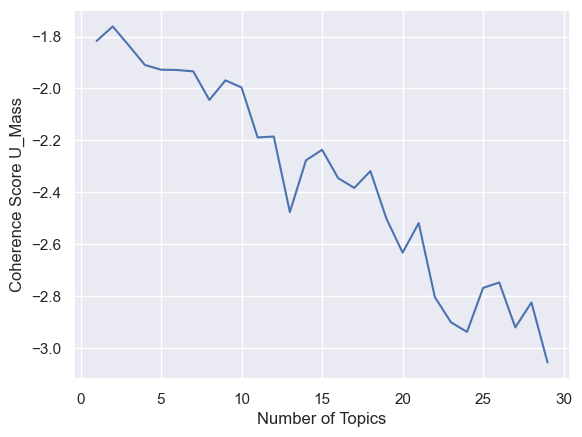

In [19]:
#Calculating the coherence score using C_umass:
topics_umass = []
score_umass = []
for i in range(1,30,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 8, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics_umass.append(i)
   score_umass.append(cm.get_coherence())
_=plt.plot(topics_umass, score_umass)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score U_Mass')
plt.show()

In [20]:
coherence_umass = pd.DataFrame({'Number of Topics': topics_umass,
                               'Coherence Score': score_umass})
coherence_umass['Sorted'] = coherence_umass['Coherence Score'].abs()
coherence_umass.sort_values(by=['Sorted'], ascending = True).head(10)

,Number of Topics,Coherence Score,Sorted
1,2,-1.761201,1.761201
0,1,-1.817231,1.817231
2,3,-1.834584,1.834584
3,4,-1.909815,1.909815
4,5,-1.927970,1.927970
5,6,-1.929117,1.929117
6,7,-1.934395,1.934395
8,9,-1.969080,1.969080
9,10,-1.996373,1.996373
7,8,-2.044537,2.044537


### Step 3b: CV Coherence Score
The coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence). According to McLevey (2021), values above 0.5 can be regarded as fairly good. However, the higher the average CV score, the better is the coherence of the number of topics (Sarkar 2019, Mishra 2022).

References:
* Mishra, M. (2022). Customer Experience: Extracting Topics From Tweets. International Journal of Market Research, 64(3), 334–353. https://doi.org/10.1177/14707853211047515
* Sarkar, D. (2019). Text Analytics with Python. In Text Analytics with Python. Apress. https://doi.org/10.1007/978-1-4842-4354-1
* McLevey, J. (2021). Doing Computational Social Science: A Practical Introduction. SAGE Publications.

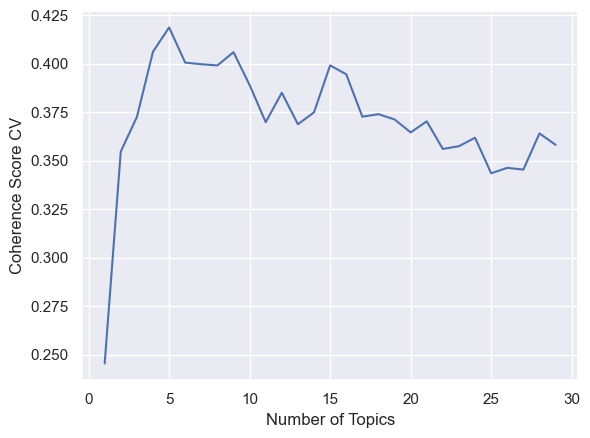

In [21]:
#Calculating the coherence score using C_v
topics_cv = []
score_cv = []
for i in range(1,30,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 8, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics_cv.append(i)
   score_cv.append(cm.get_coherence())
_=plt.plot(topics_cv, score_cv)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score CV')
plt.show()

In [22]:
coherence_v = pd.DataFrame({'Number of Topics': topics_cv,
                               'Coherence Score': score_cv})
coherence_v['Sorted'] = coherence_v['Coherence Score'].abs()
coherence_v.sort_values(by=['Sorted'], ascending = False).head(10)

,Number of Topics,Coherence Score,Sorted
4,5,0.418811,0.418811
3,4,0.406295,0.406295
8,9,0.406062,0.406062
5,6,0.400685,0.400685
6,7,0.399856,0.399856
14,15,0.399244,0.399244
7,8,0.399225,0.399225
15,16,0.394677,0.394677
9,10,0.389108,0.389108
11,12,0.385139,0.385139


### Step 3c: NPMI Coherence Score
The coherence score for C_NPMI is similar to UMASS as values closer to 0 have better coherence than larger values.

References:
* Röder, M., Both, A., & Hinneburg, A. (2015). Exploring the space of topic coherence measures. WSDM 2015 - Proceedings of the 8th ACM International Conference on Web Search and Data Mining, 399–408. https://doi.org/10.1145/2684822.2685324
* Sarkar, D. (2019). Text Analytics with Python. In Text Analytics with Python. Apress. https://doi.org/10.1007/978-1-4842-4354-1

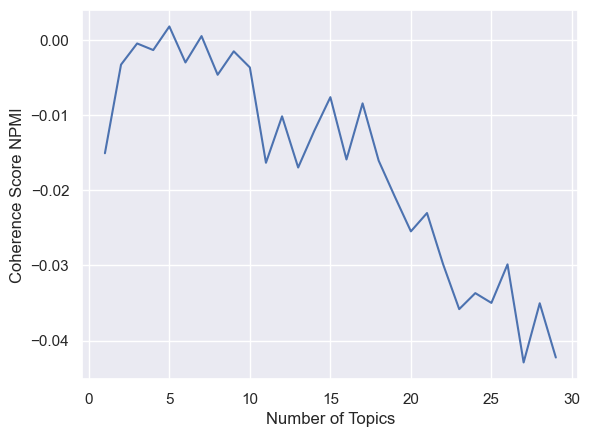

In [23]:
#Calculating the coherence score using C_npmi
topics_npmi = []
score_npmi = []
for i in range(1,30,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 2, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_npmi')
   topics_npmi.append(i)
   score_npmi.append(cm.get_coherence())
_=plt.plot(topics_npmi, score_npmi)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score NPMI')
plt.show()

In [24]:
coherence_npmi = pd.DataFrame({'Number of Topics': topics_npmi,
                               'Coherence Score': score_npmi})
coherence_npmi['Sorted'] = coherence_npmi['Coherence Score'].abs()
coherence_npmi.sort_values(by=['Sorted'], ascending = True).head(10)

,Number of Topics,Coherence Score,Sorted
2,3,-0.000458,0.000458
6,7,0.000523,0.000523
3,4,-0.001335,0.001335
8,9,-0.001502,0.001502
4,5,0.001807,0.001807
5,6,-0.002986,0.002986
1,2,-0.003277,0.003277
9,10,-0.003649,0.003649
7,8,-0.004626,0.004626
14,15,-0.007607,0.007607


## Step 5: Running the Final Model
Adapting the model according to the optimal number of topics based on the calculated coherence scores. 
As in all three calculated score, the optimal number of topics seems to vary. In order to explore different facets of the phenomenon, we select a number of 7 topics since this seems to have fairly good coherence.

In [18]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, 
                         num_topics=7, workers = 8, passes=100)

## Step 6: Extract and Visualize the Topics
We can now print out the five topics and the related words:

In [19]:
lda_model.print_topics()

[(0,
  '0.018*"influencer" + 0.012*"face" + 0.012*"argue" + 0.012*"change" + 0.010*"need" + 0.010*"examine" + 0.009*"woman" + 0.008*"draw" + 0.008*"focus" + 0.008*"use"'),
 (1,
  '0.017*"identify" + 0.014*"influencer" + 0.012*"understand" + 0.012*"provide" + 0.011*"share" + 0.011*"pandemic" + 0.011*"explore" + 0.011*"include" + 0.010*"relate" + 0.010*"help"'),
 (2,
  '0.059*"influencer" + 0.032*"brand" + 0.028*"consumer" + 0.013*"provide" + 0.013*"smi" + 0.013*"follower" + 0.012*"product" + 0.011*"affect" + 0.010*"marketer" + 0.010*"create"'),
 (3,
  '0.044*"instagram" + 0.013*"facebook" + 0.013*"examine" + 0.012*"provide" + 0.011*"engage" + 0.010*"influencer" + 0.010*"content" + 0.010*"youtube" + 0.009*"share" + 0.009*"include"'),
 (4,
  '0.025*"twitter" + 0.023*"result" + 0.020*"tweet" + 0.018*"conclusion" + 0.018*"include" + 0.014*"increase" + 0.014*"method" + 0.013*"analyze" + 0.012*"post" + 0.012*"compare"'),
 (5,
  '0.030*"identify" + 0.022*"user" + 0.020*"twitter" + 0.020*"influ

### Interactive Visualization of Topics with pyLDAvis
The above chart represents our five topics as circles. They have been drawn using a dimensionality reduction technique called PCA. The goal is to have a distance in order to avoid overlapping and make each circle unique. When I hover over a circle different words are displayed on the right, showing word frequency (blue) and estimated term frequency within the selected topic (red). Topics closer to each other are more related.

In [20]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packa

In [21]:
# Save the report
pyLDAvis.save_html(lda_display, 'LDA_VIS_Influencer_Marketing.html')

### Add topics to dataframe
We can create a new column in the dataframe which has the most probable topic that each article belong to. We can add the most probable topic by running through each summary text:

In [22]:
lda_model[corpus][1]

[(2, 0.7420445), (6, 0.2374777)]

In [23]:
reports['topic_ID'] = [sorted(lda_model[corpus][text])[0][0] 
                       for text in range(len(reports['Abstract']))]

In [24]:
reports

,Authors,Title,Year,Source title,DOI,Link,Abstract,tokens,topic_ID
0,"Donofrio A., Moraga Á.L.R., Guzmán C.A.","Russia-Ukraine, a comparative analysis of the ...",2023,Revista Latina de Comunicacion Social,10.4185/RLCS-2023-1819,https://www.scopus.com/inward/record.uri?eid=2...,"Introduction: On February 24, 2022, the Russia...","[introduction, ukraine, begin, spread, invaded...",3
1,"Thomas V.L., Fowler K.",Examining the outcomes of influencer activism,2023,Journal of Business Research,10.1016/j.jbusres.2022.113336,https://www.scopus.com/inward/record.uri?eid=2...,Academic research on influencer marketing is b...,"[prevalent, take, advise, company, good, partn...",2
2,"Barta S., Belanche D., Fernández A., Flavián M.",Influencer marketing on TikTok: The effectiven...,2023,Journal of Retailing and Consumer Services,10.1016/j.jretconser.2022.103149,https://www.scopus.com/inward/record.uri?eid=2...,This work examines the determinants of the suc...,"[examine, analyse, originality, quality, quant...",2
3,"Zhao L., Zhang M., Ming Y., Niu T., Wang Y.",The effect of image richness on customer engag...,2023,Journal of Business Research,10.1016/j.jbusres.2022.113307,https://www.scopus.com/inward/record.uri?eid=2...,Despite the dominant role of images on social ...,"[despite, image, evaluate, limit, propose, mea...",2
4,"Taufiq M., Farida N., Aryanto V.D.W., Ngatno",Evaluating Factor Influencing Consumer Purchas...,2023,Lecture Notes in Networks and Systems,10.1007/978-3-031-08093-7_30,https://www.scopus.com/inward/record.uri?eid=2...,This study mainly aimed to examine the factors...,"[aim, examine, influence, include, cash, deliv...",2
...,...,...,...,...,...,...,...,...,...
1877,"Freberg K., Graham K., McGaughey K., Freberg L.A.",Who are the social media influencers? A study ...,2011,Public Relations Review,10.1016/j.pubrev.2010.11.001,https://www.scopus.com/inward/record.uri?eid=2...,Social media influencers (SMIs) represent a ne...,"[smis, represent, shape, blog, tweet, identify...",0
1878,"Woodcock N., Broomfield N., Downer G., Starkey M.",The evolving data architecture of social custo...,2011,"Journal of Direct, Data and Digital Marketing ...",10.1057/dddmp.2010.45,https://www.scopus.com/inward/record.uri?eid=2...,Social media enables the brand to extend its p...,"[enable, extend, engage, consumer, place, chan...",0
1879,"Cheong M., Lee V.",Twittering for earth: A study on the impact of...,2010,Lecture Notes in Computer Science (including s...,10.1007/978-3-642-12101-2_13,https://www.scopus.com/inward/record.uri?eid=2...,The role of Twitter - a form of microblogging ...,"[twitter, microblogge, reflector, emerge, web,...",0
1880,[No author name available],ICWSM 2008 - Proceedings of the 2nd Internatio...,2008,ICWSM 2008 - Proceedings of the 2nd Internatio...,NaN,https://www.scopus.com/inward/record.uri?eid=2...,The proceedings contain 33 papers. The topics ...,"[contain, discuss, include, international, sen...",1


In [25]:
reports['topic'] = reports['topic_ID']

In [26]:
for i in range(len(lda_model.print_topics())):
    reports['topic'] = reports['topic'].replace(to_replace =[i], value = lda_model.print_topics()[i][1])
    
reports.head()

,Authors,Title,Year,Source title,DOI,Link,Abstract,tokens,topic_ID,topic
0,"Donofrio A., Moraga Á.L.R., Guzmán C.A.","Russia-Ukraine, a comparative analysis of the ...",2023,Revista Latina de Comunicacion Social,10.4185/RLCS-2023-1819,https://www.scopus.com/inward/record.uri?eid=2...,"Introduction: On February 24, 2022, the Russia...","[introduction, ukraine, begin, spread, invaded...",3,"0.044*""instagram"" + 0.013*""facebook"" + 0.013*""..."
1,"Thomas V.L., Fowler K.",Examining the outcomes of influencer activism,2023,Journal of Business Research,10.1016/j.jbusres.2022.113336,https://www.scopus.com/inward/record.uri?eid=2...,Academic research on influencer marketing is b...,"[prevalent, take, advise, company, good, partn...",2,"0.059*""influencer"" + 0.032*""brand"" + 0.028*""co..."
2,"Barta S., Belanche D., Fernández A., Flavián M.",Influencer marketing on TikTok: The effectiven...,2023,Journal of Retailing and Consumer Services,10.1016/j.jretconser.2022.103149,https://www.scopus.com/inward/record.uri?eid=2...,This work examines the determinants of the suc...,"[examine, analyse, originality, quality, quant...",2,"0.059*""influencer"" + 0.032*""brand"" + 0.028*""co..."
3,"Zhao L., Zhang M., Ming Y., Niu T., Wang Y.",The effect of image richness on customer engag...,2023,Journal of Business Research,10.1016/j.jbusres.2022.113307,https://www.scopus.com/inward/record.uri?eid=2...,Despite the dominant role of images on social ...,"[despite, image, evaluate, limit, propose, mea...",2,"0.059*""influencer"" + 0.032*""brand"" + 0.028*""co..."
4,"Taufiq M., Farida N., Aryanto V.D.W., Ngatno",Evaluating Factor Influencing Consumer Purchas...,2023,Lecture Notes in Networks and Systems,10.1007/978-3-031-08093-7_30,https://www.scopus.com/inward/record.uri?eid=2...,This study mainly aimed to examine the factors...,"[aim, examine, influence, include, cash, deliv...",2,"0.059*""influencer"" + 0.032*""brand"" + 0.028*""co..."


In [27]:
reports.to_excel('./Results/LDATopicResults.xlsx', index = True, header=True)